In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

sys.path.append('../')
sys.path.append('../Lib')
sys.path.append('../Protocols')
import mod_protocols
import jk_protocols
sys.path.append('../Models')
from br1977 import BR1977
from ord2011JK_v1 import ORD2011
import model_response


In [2]:
def get_high_fitness(ga_result):
    best_individual = ga_result.generations[0][0]

    for i, gen in enumerate(ga_result.generations):
        best_in_gen = ga_result.get_high_fitness_individual(i)
        if best_in_gen.fitness > best_individual.fitness:            
            best_individual = best_in_gen

    return best_individual

In [3]:
steps_in_protocol = 4
step_types=['step', 'ramp']
step_duration_bounds=(5, 1000)
step_voltage_bounds=(-120, 60)
window=2
step_size=2
LIST_OF_CURRENTS = [ 'I_Na', 'I_NaL', 'I_to', 'I_CaL', 'I_Kr', 'I_Ks', 'I_K1' ]# ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_F', 'I_CaL', 'I_K1'] 

[0, 200.0, 500.0]
[200.0, 500.0, 800.0]
|STEP: Voltage: -80, Duration: 200.0| + |RAMP: Voltage Start: -50, Voltage End: 30, Duration: 300| + |RAMP: Voltage Start: -50, Voltage End: 30, Duration: 300|


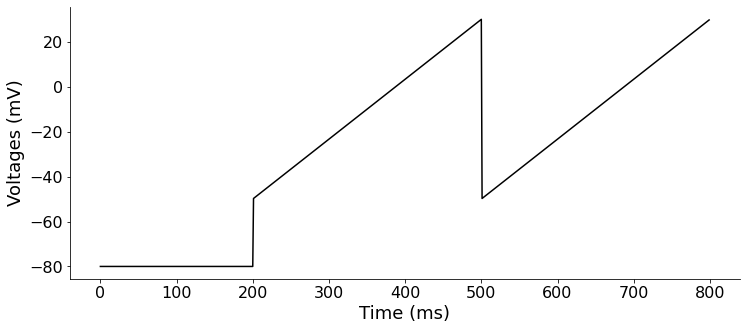

In [12]:
p_li = []
p1 = jk_protocols.VoltageClampStep(voltage=-80, duration=200.0)
p_li.append(p1)
p2 = jk_protocols.VoltageClampRamp(voltage_start=-50, voltage_end=30, duration=300) 
p_li.append(p2)
p3 = jk_protocols.VoltageClampRamp()
p3.set_to_random_step( voltage_bounds=step_voltage_bounds,    # -> (-120, 60)
                      duration_bounds=step_duration_bounds)
p_li.append(p2)

p = jk_protocols.VoltageClampProtocol(steps=p_li)
print(p.get_voltage_change_startpoints())
print(p.get_voltage_change_endpoints())
print(p)
p.get_voltage_clamp_protocol()

[200, 700, 1200]

In [8]:
trial_conditions = "trial_steps_ramps_ORD2011_256_64_4_-120_60"
current = 'I_NaL'
ga_result = pickle.load(open(f'ga_results/{trial_conditions}/ga_results_{current}_artefact_False', 'rb'))
best_individual = get_high_fitness(ga_result)
best_protocol = best_individual.protocol
best_fitness = best_individual.fitness
print(best_protocol)
print(best_fitness)

|STEP: Voltage: -115.69547260492953, Duration: 638.9592002615126| | |STEP: Voltage: -119.6223546833323, Duration: 955.168451140388| | |STEP: Voltage: -119.8576965483277, Duration: 996.8644734365002| | |RAMP: Voltage Start: 3.7172294215999893, Voltage End: -57.8159885307908, Duration: 71.3887040686221|
0.7258659654686296


In [9]:
model = None
if 'ORD2011' in trial_conditions:
    model = ORD2011(best_protocol)
elif 'BR1977' in trial_conditions:
    model = BR1977(best_protocol)  
    
tr = model_response.get_model_response_JK(model, best_protocol, prestep=5000)

scale = 1
max_contributions = tr.current_response_info.get_max_current_contributions(
                time=tr.t,
                window=window/scale,
                step_size=step_size/scale)
print(max_contributions)
tr.plot_currents_contribution(current, window=window, step_size=step_size, is_shown=True, title=current,
        saved_to=f'./ga_results/{trial_conditions}/{current}.svg')

KeyboardInterrupt: 

In [ ]:
'''
Plot
'''
plot_li = ['command_voltages', 'I_ion']+LIST_OF_CURRENTS
fig, axes = plt.subplots(len(plot_li), 1, figsize=(10, 20))    
fig.suptitle('ORD2011', fontsize=14)
for i, name in enumerate(plot_li):    
    # ax.set_title('Simulation %d'%(simulationNo))
    axes[i].set_xlim(model.times.min(), model.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    axes[i].set_ylabel(name)  
    axes[i].set_xlabel('Time (ms)') 
    if name=='command_voltages':
        axes[i].plot( model.times, tr.command_voltages, label=name, c='b') 
    else:
        axes[i].plot( model.times, model.current_response_info.get_current([name]), label=name, c='black')     
    axes[i].legend()
    axes[i].grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.96, wspace=0.5, hspace=0.15)
plt.show()
# fig.savefig(os.path.join('Results', "ORD2011-JK-scipy"), dpi=100)

In [ ]:
protocol_li = []
for i in [0, 1, 2, 3, 0, 1, 3]:
    protocol_li.append(best_protocol.steps[i])
protocol = mod_protocols.VoltageClampProtocol(steps=protocol_li)

In [ ]:
model = None
if 'ORD2011' in trial_conditions:
    model = ORD2011(protocol)
elif 'BR1977' in trial_conditions:
    model = BR1977(protocol)  
    
tr = model_response.get_model_response_JK(model, protocol)

scale = 1
max_contributions = tr.current_response_info.\
            get_max_current_contributions(
                time=tr.t,
                window=window/scale,
                step_size=step_size/scale)
print(max_contributions)
tr.plot_currents_contribution(current, window=window, step_size=step_size, is_shown=True, title=current,
        saved_to=f'./ga_results/{trial_conditions}/{current}.svg')